# Forcing Extraction Tutorial

Use daymet data with Angelo precip

In [4]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import numpy as np
import seaborn
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import sys
import pickle
from functools import partial
from datetime import datetime

parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap
import daymetpy as dm
from ulmo.nasa import daymet



model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_hillslope']
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)

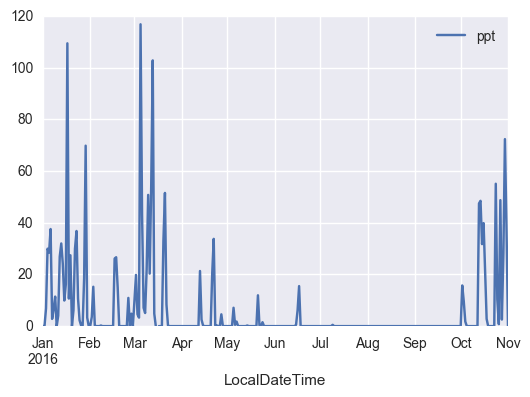

In [9]:
angelo_ppt = pickle.load( open(os.path.join(parent_dir, 'raw_data', 'elder_data', 'elder_ppt.p'),'rb') )


We first need to specify the geographic areas of interest, comprised of the collection of REW sub-basins. We'll assume that these regions are specified via shapefiles located in the `raw_data` folder. 

In [2]:
try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'

For simplicity, we'll assume that the forcing along the spatial extent of each basin is constant and equal to the forcing observed at its centroid. We could also consider implementing zonal averaging or some other more faithful approximation, but this would be much more computationally intensive, and quite likely unnecessary for lower resolution climate datasets. 

In [3]:
# load daily precip from Angelo database, stored in raw_data folder
angelo_ppt = pickle.load( open(os.path.join(parent_dir, 'raw_data', 'elder_data', 'elder_ppt.p'),'rb') )

# Load lat/lon data for each REW
points = pd.read_csv( os.path.join(parent_dir, 'raw_data', 'basins_centroids', 'points.csv') )
points = points.sort_values('cat')
rew_dfs_dict = {}
for i,row in points.iterrows():
    printstr = 'Working on REW ' + str(int(row['cat'])) + ' out of ' + str(np.max(points['cat']))
    print(printstr)
    df = dm.daymet_timeseries(lat=row.lat, lon=row.lon, start_year=start_date.year, end_year=stop_date.year, 
                      as_dataframe=True, download_dname=None, verbose=False)
    
    # daymet removes 12/31 on leap years; fill with 12/30 data
    for year in set(df.index.year):
        try:
            assert(df.loc[datetime(year,12,31)])
        except:
            df.loc[datetime(year,12,31)] = df.loc[datetime(year,12,30)].copy()
    df = df.sort_index()
    df.columns = ['year','yday','dayl','ppt','srad','swe','tmax','tmin','vp']
    df['es'] = meteo.es_calc(airtemp= np.mean([df['tmax'],df['tmin']]))
    df['rh'] = df['vp']/df['es']
    df['rh'].loc[df.rh>1.0] = 1.0
    elevation = rew_config[int(row['cat'])]['elevation']
    df['p'] = meteo.airpress_calc(elevation)
    df = df.drop('ppt', 1)
    df['ppt'] = angelo_ppt.loc[df.index]/10.0
    df['tmean'] = (df['tmax'] + df['tmin'])/2.0
    rew_dfs_dict[int(row['cat'])] = df.copy()

Working on REW 2 out of 6


AttributeError: 'DataFrame' object has no attribute 'year'

In [ ]:
# Remove any intercepted rainfall 
# only run this once! 
for rew_id in rew_dfs_dict.keys():
    maxvals = rew_dfs_dict[rew_id].apply(lambda row: np.max([row['ppt'] - rew_config[rew_id]['interception_factor'], 0]),axis=1)
    percent_intercepted = 1-np.sum(maxvals)/np.sum(rew_dfs_dict[rew_id].ix[:,'ppt'])
    print('REW %s intercepted fraction = %.2f'%(str(rew_id), percent_intercepted))
    rew_dfs_dict[rew_id].ix[:,'ppt'] = maxvals

The last remaining forcing timeseries required by the model presented in this tutorial is daily average potential evapotranspiration (in units of cm/day). Here, we'll use the Priestly-Taylor equation to compute this forcing.   Before we get started, we need to build some helper functions. 

We finally have all the pieces to compute PET. We'll use the Priestley-Taylor implementation from the `evap` module. We assume that the soil heat flux is zero at the daily timescale. Once all forcing timeseries have been computed, we save to `rew_forcing.p` in the `model_data` directory. 

In [ ]:
# Using Eqn 50 From Allen (1998) to get solar radiation from max/min temp difference
kRs = 0.18

# centroids of basins
centroids = pd.read_csv( os.path.join(parent_dir, 'raw_data','basins_centroids', 'points.csv') )

# get forcing dates
rng = df.index

for rew_id in rew_dfs_dict.keys():
    doy = [rng[i].timetuple().tm_yday for i in range(len(rng))]
    N, Rext = meteo.sun_NR(doy, float(centroids['lat'].loc[centroids['cat']==rew_id]))
    Rext_MJ = Rext/(10.0**6)
    tmax = rew_dfs_dict[rew_id]['tmax']
    tmin = rew_dfs_dict[rew_id]['tmin']
    tmean = rew_dfs_dict[rew_id]['tmean']
    Rs = kRs*np.sqrt(tmax-tmin)*Rext
    pet = evap.hargreaves(tmin, tmax, tmean, Rext_MJ)
    pet = pet.ffill()
    rew_dfs_dict[rew_id]['pet'] = pet/10.0  #into units of cm/day

# Aggregate data to climate groups

The model itself requires forcing data to be indexed by climate groups, not REW id's. For this tutorial, each REW comprises its own climate group. However, it may be that the user would want to lump REWs with similar climates into groups, within which each REW is forced with identical data. Here, we demonstrate a straightforward aggregation procedure that would take the average of each forcing variable across the REWs in each climate group. 

In [ ]:
# the forcing dictionary must have climate_group id's as keys. 
# for the time being, we will merge REWs within each climate group
# using the mean of the forcings for all REWs in the climate group. 
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = {}
for climate_group in set([rew_config[i]['climate_group'] for i in rew_config.keys()]):
    rew_ids_in_climate_group = [i for i in rew_config.keys() if rew_config[i]['climate_group']==climate_group]
    rew_dfs  = [rew_dfs_dict[rew_id] for rew_id in rew_ids_in_climate_group]
    df = pd.concat(rew_dfs)
    df = df.groupby(df.index).mean()
    climate_group_forcing[climate_group] = df

    
# Now save the dictionary of dataframes, where the keys are climate groups and each entry is a pandas dataframe 
# containing the forcings associated with that climate group. 
pickle.dump( climate_group_forcing, open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "wb" ) )

# Also save the original REW climatic forcing dataframe. This will be used for the temperature model
pickle.dump( rew_dfs_dict, open( os.path.join(parent_dir,'model_data','rew_forcing.p'), "wb" ) )

In [ ]:
plt.plot(rew_dfs_dict[11].srad.loc['2012'])